In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/EMIP-Toolkit')
sys.path.append('/content/drive/MyDrive/EMIP-Toolkit/emtk')
sys.path.append('/content/drive/MyDrive/EMIP-Toolkit/emtk/parsers')
print(sys.path)

['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/EMIP-Toolkit', '/content/drive/MyDrive/EMIP-Toolkit/emtk', '/content/drive/MyDrive/EMIP-Toolkit/emtk/parsers']


In [3]:
import parsers
import aoi
import visualization
import util

#Downgrade Pandas and Numpy  - NOT WORKING IN PYTHON 3.12!!

In [4]:
!pip uninstall pandas -y
#!pip install pandas==1.5.3
!pip install pandas==2.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 60.0 MB/s eta 0:00:00


In [5]:
!python --version
#!pip uninstall numpy -y
#!pip install numpy==1.23.5
#!python -m venv env
#!source env/bin/activate
!pip install numpy==1.26.0

Python 3.12.11


# Parsing raw data from the EMIP dataset

In [4]:
import pandas as pd
import os

desired_path = '/content/drive/MyDrive/EMIP-Toolkit/emtk/parsers'

os.chdir(desired_path)
print(os.getcwd())

from eye_events import eye_event_list, get_eye_event_columns
from samples import get_samples_columns, samples_list

from emtk.fixation_classification import idt_classifier

/content/drive/MyDrive/EMIP-Toolkit/emtk/parsers


In [5]:


# Replace this path with your desired directory
#desired_path = '/content/drive/MyDrive/EMIP-Toolkit'
desired_path = os.path.join(
    '/content/drive/MyDrive/EMIP-Toolkit/emtk/datasets/EMIP',
    'EMIP-Toolkit- replication package',
    'emip_dataset'
)

os.chdir(desired_path)
print(os.getcwd())

entries = os.listdir(os.getcwd())
print(entries)



/content/drive/MyDrive/EMIP-Toolkit/emtk/datasets/EMIP/EMIP-Toolkit- replication package/emip_dataset
['date.txt', 'emip_metadata.csv', 'stimuli', 'rawdata', 'EMIP_DataCollection_Materials', 'emip_eye_events.csv', 'emip_samples.csv']


## Read gender from the metadata file


In [6]:
# Load metadata
#METADATA_FILE = '/emtk/datasets/EMIP/EMIP-Toolkit- replication package/emip_dataset/emip_metadata.csv'
METADATA_FILE = 'emip_metadata.csv'
try:
    metadata_df = pd.read_csv(METADATA_FILE)
    print(f"Loaded metadata for {len(metadata_df)} participants")

    # Create a mapping from participant ID to gender
    # Assuming 'id' column in metadata corresponds to experiment_id/participant_id
    gender_mapping = dict(zip(metadata_df['id'].astype(str), metadata_df['gender']))
    print(f"Gender mapping created for {len(gender_mapping)} participants")

except FileNotFoundError:
    print(f"Warning: Metadata file '{METADATA_FILE}' not found. Gender will be set to Male.")
    gender_mapping = {}
except Exception as e:
    print(f"Error loading metadata: {e}. Gender will be set to Male.")
    gender_mapping = {}

Loaded metadata for 216 participants
Gender mapping created for 216 participants


In [7]:
# Replace this path with your desired directory
desired_path = '/content/drive/MyDrive/EMIP-Toolkit'


os.chdir(desired_path)
print(os.getcwd())

#entries = os.listdir(os.getcwd())
#print(entries)

/content/drive/MyDrive/EMIP-Toolkit


In [8]:
RAWDATA_MODULE = "emtk/datasets/EMIP/EMIP-Toolkit- replication package/emip_dataset/rawdata"

SAMPLE_BASE_COLUMNS = ['Time', 'Type', 'Trial', 'L Raw X [px]', 'L Raw Y [px]', 'R Raw X [px]',
                       'R Raw Y [px]', 'L Dia X [px]', 'L Dia Y [px]', 'L Mapped Diameter [mm]',
                       'R Dia X [px]', 'R Dia Y [px]', 'R Mapped Diameter [mm]', 'L CR1 X [px]',
                       'L CR1 Y [px]', 'L CR2 X [px]', 'L CR2 Y [px]', 'R CR1 X [px]', 'R CR1 Y [px]',
                       'R CR2 X [px]', 'R CR2 Y [px]', 'L POR X [px]', 'L POR Y [px]', 'R POR X [px]',
                       'R POR Y [px]', 'Timing', 'L Validity', 'R Validity', 'Pupil Confidence',
                       'L Plane', 'R Plane', 'L EPOS X', 'L EPOS Y', 'L EPOS Z', 'R EPOS X', 'R EPOS Y',
                       'R EPOS Z', 'L GVEC X', 'L GVEC Y', 'L GVEC Z', 'R GVEC X', 'R GVEC Y',
                       'R GVEC Z', 'Frame', 'Aux1']

def EMIP(sample_size: int = 216):
    """Import the EMIP dataset.

    Parameters
    ----------
    sample_size : int, optional (default 216)
        Number of subjects to be processed.

    Returns
    -------
    pandas.DataFrame
        Pandas dataframe of eye events from every experiment in the dataset.
    """
    eye_events = []
    samples = []
    parsed_experiments = []

    # go over .tsv files in the rawdata directory add files and count them
    # r = root, d = directories, f = files
    for r, _, f in os.walk(RAWDATA_MODULE):
        f = [name for name in f if name and name[0].isdigit()]
        print(len(f))
        #f.sort()
        f.sort(key=lambda name: int(name.split('_')[0]))
        for file in f:
            if '.tsv' in file:
                experiment_id = file.split('/')[-1].split('_')[0]

                if experiment_id not in parsed_experiments:
                    parsed_experiments.append(experiment_id)

                    #Get gender for this participant
                    participant_gender = gender_mapping.get(experiment_id, None)
                    if participant_gender is None:
                        print(f"Warning: No gender data found for participant {experiment_id}")
                        participant_gender = "male"
                    else:
                        print(f"Gender for participant {experiment_id}: {participant_gender}")


                    new_eye_events, new_samples = read_SMIRed250(
                        root_dir=r,
                        filename=file,
                        experiment_id=experiment_id,
                        gender = participant_gender
                    )

                    eye_events.extend(new_eye_events)
                    samples.extend(new_samples)

                else:
                    print("Error, experiment already in dictionary")

            sample_size -= 1
            if sample_size == 0:
                break

    eye_events_df = pd.DataFrame(eye_events, columns=get_eye_event_columns())

    # Convert columns with numbers formatted as strings to dtype of numeric
    samples_df = pd.DataFrame(
        samples, columns=get_samples_columns(SAMPLE_BASE_COLUMNS))
    id_dfs = samples_df[["experiment_id", "participant_id", "trial_id"]]
    samples_df = samples_df.apply(pd.to_numeric, errors='ignore')
    samples_df[id_dfs.columns] = id_dfs

    return eye_events_df, samples_df

In [9]:
EYE_TRACKER = "SMIRed250"
FILE_TYPE = ".tsv"
STIMULI_MODULE = "emtk/datasets/EMIP/EMIP-Toolkit- replication package/emip_dataset/stimuli"

def read_SMIRed250(root_dir, filename, experiment_id,
                   minimum_duration=50, sample_duration=4, maximum_dispersion=25, gender = None) -> list:
    """Read tsv file from SMI Red 250 eye tracker

    Parameters
    ----------
    root_dir : str
        Path to directory that contains the asc file.

    filename : str
        Name of asc file.

    experiment_id : str
        Id of the experiment contained in the file.

    Returns
    -------
    list
        List of eye events. Each eye event is represented as a list of eye event features.
    """

    # Reads raw data and sets up
    tsv_file = open(os.path.join(root_dir, filename))
    #print(filename)
    print("parsing file:", filename.split("/")[-1])
    text = tsv_file.read()
    text_lines = text.split('\n')

    trial_id = 0
    stimuli_name = ""
    raw_fixations = []
    active = False  # Indicates whether samples are being recorded in trials
    # The goal is to skip metadata in the file

    eye_events = []
    samples = []

    # Parses the data into dataframes
    for line in text_lines:
        token = line.split("\t")

        if len(token) < 3:
            continue

        if active:
            # Filter MSG samples if any exist, or R eye is inValid
            if token[1] == "SMP" and token[27] != "-1":
                # Get x and y for each sample (right eye only)
                # [23] R POR X [px]	 '0.00',
                # [24] R POR Y [px]	 '0.00',

                new_sample = samples_list(
                    eye_tracker=EYE_TRACKER,
                    experiment_id=experiment_id,
                    participant_id=experiment_id,
                    filename=filename,
                    trial_id=str(trial_id),
                    stimuli_module=STIMULI_MODULE,
                    stimuli_name=stimuli_name,
                    token=token,
                    gender = gender
                )

                samples.append(new_sample)

                raw_fixations.append(
                    [int(token[0]), float(token[23]), float(token[24])])

        if token[1] == "MSG" and token[3].find(".jpg") != -1:

            if active:
                filter_eye_events = idt_classifier(raw_fixations=raw_fixations,
                                                   minimum_duration=minimum_duration,
                                                   sample_duration=sample_duration,
                                                   maximum_dispersion=maximum_dispersion)
                # TODO saccades

                for timestamp, duration, x_cord, y_cord in filter_eye_events:

                    new_eye_event = eye_event_list(eye_tracker=EYE_TRACKER,
                                                   experiment_id=experiment_id,
                                                   participant_id=experiment_id,
                                                   filename=filename,
                                                   trial_id=str(trial_id),
                                                   stimuli_module=STIMULI_MODULE,
                                                   stimuli_name=stimuli_name,
                                                   duration=duration,
                                                   timestamp=timestamp,
                                                   x0=x_cord,
                                                   y0=y_cord,
                                                   token=token,
                                                   pupil=0,
                                                   eye_event_type="fixation",
                                                   gender = gender)

                    eye_events.append(new_eye_event)

                trial_id += 1

            # Message: vehicle_java2.jpg
            stimuli_name = token[3].split(' ')[-1]
            print(stimuli_name)
            raw_fixations = []
            active = True

    # Adds the last trial
    filter_fixations = idt_classifier(raw_fixations=raw_fixations,
                                      minimum_duration=minimum_duration,
                                      sample_duration=sample_duration,
                                      maximum_dispersion=maximum_dispersion)

    for timestamp, duration, x_cord, y_cord in filter_fixations:

        new_eye_event = eye_event_list(eye_tracker=EYE_TRACKER,
                                       experiment_id=experiment_id,
                                       participant_id=experiment_id,
                                       filename=filename,
                                       trial_id=str(trial_id),
                                       stimuli_module=STIMULI_MODULE,
                                       stimuli_name=stimuli_name,
                                       duration=duration,
                                       timestamp=timestamp,
                                       x0=x_cord,
                                       y0=y_cord,
                                       token=token,
                                       pupil=0,
                                       eye_event_type="fixation",
                                       gender = gender)

        eye_events.append(new_eye_event)

    print(trial_id)
    return eye_events, samples

# Load the data from the TSVs - sample size is configurable


In [11]:
#eye_events, samples = EMIP(sample_size = 10)
eye_events, samples = EMIP(sample_size = 10)

216
Gender for participant 1: male
parsing file: 1_rawdata.tsv
instruction_calibration.jpg
instruction_comprehension.jpg
vehicle_java.jpg
mupliple_choice_vehicle.jpg
instruction_comprehension.jpg
rectangle_java.jpg
mupliple_choice_rectangle.jpg
6
Gender for participant 2: male
parsing file: 2_rawdata.tsv
instruction_calibration.jpg
instruction_comprehension.jpg
rectangle_java2.jpg
mupliple_choice_rectangle.jpg
instruction_comprehension.jpg
vehicle_java2.jpg
mupliple_choice_vehicle.jpg
6
Gender for participant 3: female
parsing file: 3_rawdata.tsv
instruction_calibration.jpg
instruction_comprehension.jpg
vehicle_java2.jpg
mupliple_choice_vehicle.jpg
instruction_comprehension.jpg
rectangle_java2.jpg
mupliple_choice_rectangle.jpg
6
Gender for participant 4: male
parsing file: 4_rawdata.tsv
instruction_calibration.jpg
instruction_comprehension.jpg
rectangle_java2.jpg
mupliple_choice_rectangle.jpg
instruction_comprehension.jpg
vehicle_java2.jpg
mupliple_choice_vehicle.jpg
6
Gender for parti

/tmp/ipython-input-2453978474.py:76: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  samples_df = samples_df.apply(pd.to_numeric, errors='ignore')


In [ ]:
samples.head()



In [ ]:
eye_events.head()

In [12]:
if eye_events.empty and samples.empty:
  print('Both eye_events and samples dataframes are empty')
else:
  print('Both eye_events and samples dataframes are not empty')

Both eye_events and samples dataframes are not empty


# **EXPORTING SAMPLES AND EYE EVENTS TO CSVs**

In [16]:

desired_path = os.path.join(
    '/content/drive/MyDrive/EMIP-Toolkit/emtk/datasets/EMIP',
    'EMIP-Toolkit- replication package',
    'emip_dataset'
)

os.chdir(desired_path)
print(os.getcwd())

entries = os.listdir(os.getcwd())
print(entries)

/content/drive/MyDrive/EMIP-Toolkit/emtk/datasets/EMIP/EMIP-Toolkit- replication package/emip_dataset
['date.txt', 'emip_metadata.csv', 'stimuli', 'rawdata', 'EMIP_DataCollection_Materials']


In [17]:

try:
    # Define the filenames for the output files
    eye_events_output_file = 'emip_eye_events.csv'
    samples_output_file = 'emip_samples.csv'

    # Export the eye_events DataFrame
    print(f"Exporting eye events data to {eye_events_output_file}...")
    eye_events.to_csv(eye_events_output_file, index=False)
    print("Eye events export complete.")

    # Export the samples DataFrame
    print(f"\nExporting samples data to {samples_output_file}...")
    samples.to_csv(samples_output_file, index=False)
    print("Samples export complete.")

    print("\nBoth files have been successfully saved to your current directory.")

except NameError:
    print("Error: Make sure 'eye_events' and 'samples' exist before exporting.")
except Exception as e:
    print(f"An error occurred during export: {e}")

Exporting eye events data to emip_eye_events.csv...
Eye events export complete.

Exporting samples data to emip_samples.csv...
Samples export complete.

Both files have been successfully saved to your current directory.


# Test code - printing contents of data frames eye_events and samples


In [13]:
unique_participants = eye_events['participant_id'].unique()
print(unique_participants)

unique_participants = eye_events['gender'].unique()
print(unique_participants)

unique_participants = eye_events['eye_event_type'].unique()
print(unique_participants)

#pupil is intentionally set to zero here
unique_participants = eye_events['pupil'].unique()
print(unique_participants)

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10']
['male' 'female']
['fixation']
[0]


In [23]:
unique_participants = samples['participant_id'].unique()
print(unique_participants)

unique_participants = samples['gender'].unique()
print(unique_participants)


['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43' '44'
 '45' '46' '47' '48' '49' '50']
['male' 'female']


# Read the corrected EMIP Dataset - append gender to it as well

In [14]:
desired_path = os.path.join(
    '/content/drive/MyDrive/EMIP-Toolkit/emtk/datasets/EMIP',
    'EMIP-Toolkit- replication package',
    'Corrected EMIP Dataset'
)

os.chdir(desired_path)
print(os.getcwd())

/content/drive/MyDrive/EMIP-Toolkit/emtk/datasets/EMIP/EMIP-Toolkit- replication package/Corrected EMIP Dataset


In [16]:
CORRECTED_DATASET_FILE = 'finalset_line_part.csv'
try:
    corrected_df = pd.read_csv(CORRECTED_DATASET_FILE)
    participants = corrected_df['participant'].unique()
    print(f"Loaded corrected data set for {len(participants)} participants")

    corrected_df['gender'] = corrected_df['participant'].astype(str).map(gender_mapping)

    print(f"Loaded corrected data set with {len(corrected_df)} fixation points")

except FileNotFoundError:
    print(f"Warning: CSV file '{CORRECTED_DATASET_FILE}'not file")
except Exception as e:
    print(f"Error loading corrected dataset: {e}.")


Loaded corrected data set for 159 participants
Loaded corrected data set with 61799 fixation points


In [17]:
participants_with_gender = corrected_df[['participant', 'gender']].drop_duplicates()
participants_with_gender = participants_with_gender.sort_values('participant').reset_index(drop=True)
print(participants_with_gender)

     participant  gender
0              1    male
1              3  female
2              4    male
3              5    male
4              6    male
..           ...     ...
154          211  female
155          212    male
156          214    male
157          215    male
158          216  female

[159 rows x 2 columns]


In [20]:
corrected_df.head()

,Unnamed: 0,trial,participant,code_file,code_language,timestamp,duration,x_cord,y_cord,aoi_x,aoi_y,aoi_width,aoi_height,token,length,srcML,quality,line,part,gender
0,0,2,135,rectangle_java2.jpg,rectangle_java2.jpg,3678763539,64,809.586875,357.589375,809,370,10,15,=,1,class->block->constructor->block->block_conten...,75,5,2,male
1,1,2,135,rectangle_java2.jpg,rectangle_java2.jpg,3679003436,92,678.156957,232.652609,660,225,47,15,class,5,class,75,1,2,male
2,2,2,135,rectangle_java2.jpg,rectangle_java2.jpg,3679099463,92,668.989565,233.655652,660,225,47,15,class,5,class,75,1,2,male
3,3,2,135,rectangle_java2.jpg,rectangle_java2.jpg,3679211458,64,655.791875,239.992500,660,225,47,15,class,5,class,75,1,2,male
4,4,2,135,rectangle_java2.jpg,rectangle_java2.jpg,3679455448,76,750.404211,228.840000,717,225,87,15,Rectangle,9,class->name,75,1,3,male


In [19]:
code_files = corrected_df['code_file'].unique()
print(code_files)

code_files = corrected_df['code_language'].unique()
print(code_files)

['rectangle_java2.jpg' 'vehicle_java2.jpg' 'vehicle_java.jpg'
 'rectangle_java.jpg' 'rectangle_python.jpg' 'vehicle_python.jpg']
['rectangle_java2.jpg' 'vehicle_java2.jpg' 'vehicle_java.jpg'
 'rectangle_java.jpg' 'rectangle_python.jpg' 'vehicle_python.jpg']


#Basic analysis

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

Using srcML tags to identify the the unique AOI and fixation duration.

In [22]:
aoi_types = corrected_df['srcML'].unique()
#print(f"Analyzing {len(aoi_types)} AOIs: {aoi_types}\n")


results = {}
for aoi in aoi_types:

    aoi_df = corrected_df[corrected_df['srcML'] == aoi]

    male_durations = aoi_df[aoi_df['gender'] == 'male']['duration'].dropna()
    female_durations = aoi_df[aoi_df['gender'] == 'female']['duration'].dropna()

    # Only perform the test if there is one male fixation and one female fixation available
    if len(male_durations) > 1 and len(female_durations) > 1:
        print(f"Analyzing male fixation durations {len(male_durations)} vs female {len(female_durations)} for AOI: {aoi}\n")
        stat, p_value = mannwhitneyu(male_durations, female_durations, alternative='two-sided')
        results[aoi] = {'statistic': stat, 'p_value': p_value}
    else:
        results[aoi] = {'statistic': None, 'p_value': None}

# Print the statistical results
print("--- Statistical Test Results (Mann-Whitney U) ---")
for aoi, result in results.items():
    if result['p_value'] is not None:
        print(f"AOI: {aoi:<20} | P-value: {result['p_value']:.4f}", end="")
        if result['p_value'] < 0.05:
            print(" (Statistically Significant)")
        else:
            print("")
    else:
        print(f"AOI: {aoi:<20} | Not enough data to compare.")


Analyzing male fixation durations 1028 vs female 174 for AOI: class->block->constructor->block->block_content->expr_stmt->expr->operator

Analyzing male fixation durations 483 vs female 71 for AOI: class

Analyzing male fixation durations 866 vs female 122 for AOI: class->name

Analyzing male fixation durations 162 vs female 38 for AOI: class->specifier

Analyzing male fixation durations 391 vs female 81 for AOI: class->block->decl_stmt->decl->type->specifier

Analyzing male fixation durations 1456 vs female 233 for AOI: class->block->constructor->name

Analyzing male fixation durations 1541 vs female 276 for AOI: class->block->function->type->name

Analyzing male fixation durations 1489 vs female 261 for AOI: class->block->function->type->specifier

Analyzing male fixation durations 4410 vs female 786 for AOI: class->block->constructor->block->block_content->expr_stmt->expr->name->name->operator->name

Analyzing male fixation durations 3561 vs female 566 for AOI: class->block->decl_st

# Visualization - NEED TO FIX - NOT WORKING AFTER UPDATES

#Raw data (samples), filtered fixations, saccades, and aoi

In [16]:
experiment_id = '1'   #Test code
trial_id = '2'

In [17]:
trial_data = eye_events.loc[(eye_events['experiment_id'] == experiment_id) &
                            (eye_events['trial_id'] == trial_id)]

samples_data = samples.loc[(samples['experiment_id'] == experiment_id) &
                            (samples['trial_id'] == trial_id)]

visualization.draw_trial(trial_data, samples_data, draw_raw_data = True, draw_aoi = True, draw_saccade=True,draw_number=True, sample_x_col="R POR X [px]", sample_y_col="R POR Y [px]")

AttributeError: 'DataFrame' object has no attribute 'append'

/content/drive/MyDrive/EMIP-Toolkit/emtk/visualization/heatmap.py:62: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ax=ax, x=x_cords, y=y_cords,


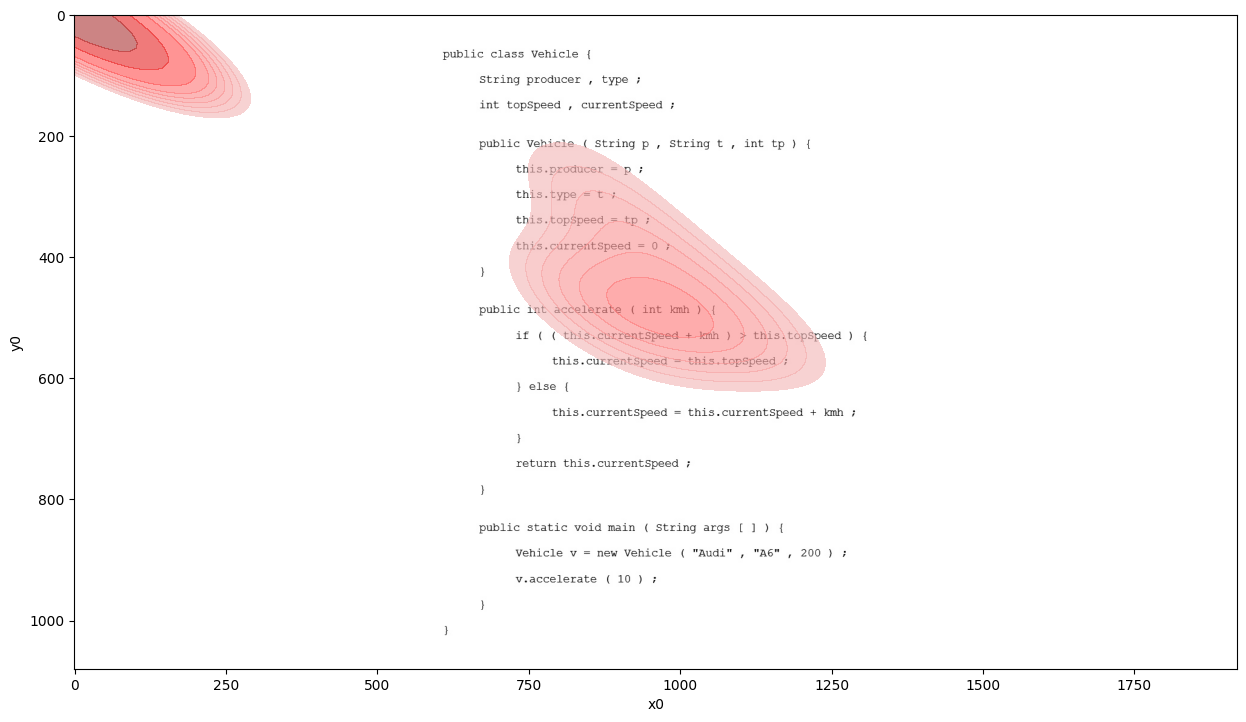

In [18]:
visualization.heatmap(trial_data)

In [19]:
visualization.fixation_duration(trial_data)

AttributeError: 'DataFrame' object has no attribute 'append'